## Part 0 -  Utiles

### Importing the libraries

In [ ]:
import os
import gdown
import torch
import random
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans


!gdown --id 1GsqEEsXnv7zXYwK2PJIX_5-7WVz4o53U
gdown.download(
    "https://drive.google.com/uc?export=download&confirm=pbef&id=1taRnS_VkYrls0pMDMdjwQUQYo0PzttL7"
)
!unzip /content/dataset.zip


###Use cuda if available


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Part 1 - Data Preprocessing



###Importing the dataset

Data example:


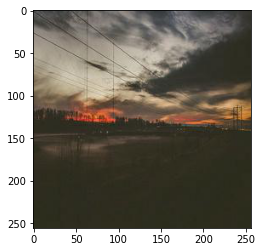

In [ ]:
class ImagesLoader(Dataset):
  def __init__(self,path) -> None:
    self.path = path
    self.images = os.listdir(path)
    self.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    ])

  def __len__(self) -> int:
    return len(self.images)


  def __getitem__(self, idx):
    img = self.images[idx % len(self.images)]
    image_path = os.path.join(self.path, img)
    img =  Image.open(image_path).convert('RGB')
    #img.show()
    img = self.transform(img)
    return img

monet_data=ImagesLoader("/content/dataset/monet_jpg")
photo_data=ImagesLoader("/content/dataset/photo_jpg")

print("Data example:")
for i in range(2):
  plt.imshow(photo_data[i].permute(1, 2, 0))


## Part 2 - Image Selection
We want to select images that best represent the latent space.
Therefore our approach was to embedd all the data into lower dimentaion space, then cluster data embedded vectors into 30 clusters (as the number of images we are allowed to use) and the pick from each claster to vector closest to cluster center (and the corresponding image) with the assumption they will represent best the image space.

In order to embedd the images we train autoencoder and use it's encoder.



###Create Autoencoder model/architecture

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
class ImagesAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid(),
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


### Training autoencoder
Hyperparams.

In [ ]:
model = ImagesAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00015)
train_loader = DataLoader(monet_data, batch_size=32, shuffle=True)

Running model training.

In [ ]:

import pdb
import sys
def train_embedder(epochs = 25):
    if os.path.exists("/content/embedd_model.pth"):
        model.load_state_dict(torch.load("/content/embedd_model.pth"))
        return model

    model.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()

            output = model(batch)
            loss = criterion(batch, output)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch}/{epochs} loss: {train_loss}")

    torch.save(model.state_dict(), "/content/embedd_model.pth")
    return model

In [ ]:
embedder = train_embedder(2)

Epoch 1/2 loss: 0.0689937137067318
Epoch 2/2 loss: 0.0390746247023344


### Test "accuracy"

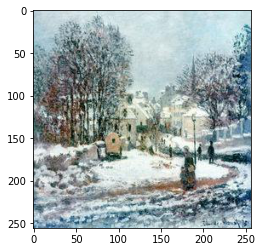

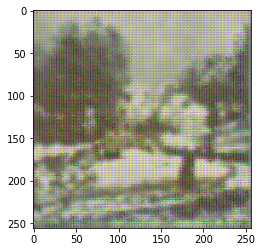

In [ ]:
def test_autoencoder():
    i = np.random.randint(0, len(monet_data))
    img = monet_data[i]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

    with torch.no_grad():
        reconstructed = embedder(img.unsqueeze(0))
    plt.imshow(reconstructed.squeeze(0).permute(1, 2, 0))
    plt.show()

test_autoencoder()

#Embed monet images into lower dimention space by appling autoencoder.

In [ ]:
from typing import Dict,Tuple
loader_indiv = DataLoader(monet_data, batch_size = 1, shuffle = False)
def embed_image(embedder,loader=loader_indiv)->Tuple[Dict,np.stack]:
  embedder.to(device)
  embedder.eval()
  embedded_dict = {}
  embedded_data = []
  with torch.no_grad():
    for index, sample in enumerate(loader):
      sample = sample.to(device)
      output = embedder.encoder(sample)
      embedded_dict[index] = output.detach().cpu().numpy()
      embedded_data.append(output.detach().cpu().numpy())
  return embedded_dict, np.stack(embedded_data)

In [ ]:
embedded_dict, embedded_data = embed_image(embedder)

# Cluster embedded data using K-means
# taking 30 images, 1 from each cluster.

In [ ]:
from sklearn.cluster import KMeans
def get_centroids(data,*args,**kwargs):
  kmeans = KMeans(*args,**kwargs)
  kmeans.fit(data)
  _ = kmeans.predict(data)
  return kmeans.cluster_centers_

def get_closest_to_centroids(data,n_clusters,*args,**kwargs):
  data = data.reshape(300,-1)
  centroids=get_centroids(data,n_clusters,*args,**kwargs)
  closest_arr=[]
  for i,centroid in enumerate(centroids):
     distances = np.linalg.norm(data - centroid, axis=1)
     closest_idx = np.argmin(distances)
     closest_to_cent = data[closest_idx, :]
     closest_arr.append(closest_to_cent.reshape(1, 32, 64, 64))
  return closest_arr

def get_images(embedded_dict, embedded_data,original_images, n_clusters, *args, **kwargs):
    images=[]
    closest_embedded = get_closest_to_centroids(embedded_data,n_clusters,*args,**kwargs)
    for vector in closest_embedded:
        keys = list(embedded_dict.keys())
        values = list(embedded_dict.values())
        image_index = next(key for key, value in zip(keys, values) if np.allclose(value, vector))
        image = original_images[image_index]
        images.append(image)
    return torch.stack(images)

monet_30 = get_images(embedded_dict, embedded_data,monet_data,30)


# Augment moent train images

torch.Size([60, 3, 256, 256])


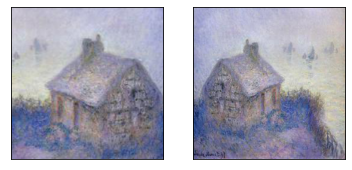

In [ ]:
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transforms_crop = torch.nn.Sequential(
    T.RandomResizedCrop(256,(0.1,0.7)),
    T.RandomHorizontalFlip(p=0.2),
)
transform_flip=torch.nn.Sequential(
    T.RandomResizedCrop(256,(0.90,1)),
    T.RandomHorizontalFlip(p=0.2),
)
monet_30=monet_30.to(device)
def augment():
    return torch.cat((transforms_crop(monet_30),transform_flip(monet_30)),0)

transformed=augment()
print(transformed.shape)
show([transformed[2], monet_30[2]])
monet_train=torch.cat((monet_30,transformed),0)

Create dataset in which we will run our gans.

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, monet_ds, photo_ds):
        self.monet_ds = monet_ds
        self.photo_ds = photo_ds

    def __len__(self):
        return max(len(self.monet_ds), len(self.photo_ds))

    def __getitem__(self, idx):
        monet_idx = idx % len(self.monet_ds)
        photo_idx = idx % len(self.photo_ds)

        monet_img = self.monet_ds[monet_idx]
        photo_img = self.photo_ds[photo_idx]

        return monet_img, photo_img

In [ ]:
train_dataset=TrainDataset(monet_train,photo_data)

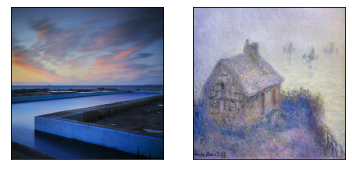

In [ ]:
show([photo_data[9], monet_train[2]])


### Part 3 - style gan

imports

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


Load pics

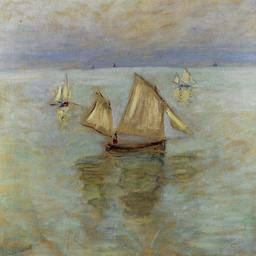

torch.Size([1, 3, 128, 128])


In [ ]:
############################################################################################
imsize = 128 #512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

to_pil = T.ToPILImage()

def image_loader(image):
    # convert the tensor to PIL image using above transform
    image = to_pil(image)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


#style_img = image_loader("./data/images/neural-style/picasso.jpg")
#content_img = image_loader("./data/images/neural-style/dancing.jpg")


# define a transform to convert a tensor to PIL image
to_pil = T.ToPILImage()

# convert the tensor to PIL image using above transform
img = to_pil(monet_train[3])
# display the PIL image
img.show()

style_img = image_loader(monet_train[3])
content_img = image_loader(photo_data[3])

print(style_img.size())
content_img.clone()
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"



Show pic

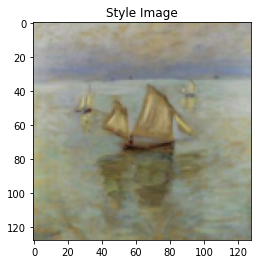

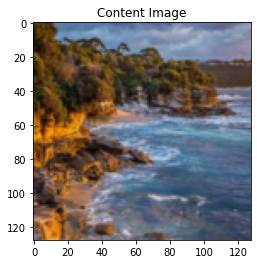

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


ContentLoss

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


Style Loss

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
#cnn as base model- better for image representation (can be False pretrained)
cnn = models.vgg19(pretrained=True).features.to(device).eval()


NameError: ignored

In [ ]:
import pickle

pickle.dump(monet_train,"/content/my_files/monet_train_set.pkl",wb)
pickle.dump(photo_data,"/content/my_files/plain_images.pkl",wb)
pickle.dump(cnn,"/content/my_files/cnn_model.pkl",wb)

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


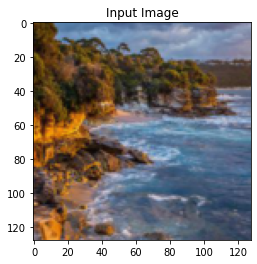

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Gradient Descent


In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Run style transfer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=100,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-33-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-33-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 23.122635 Content Loss: 17.204027

run [100]:
Style Loss : 13.057603 Content Loss: 12.594029



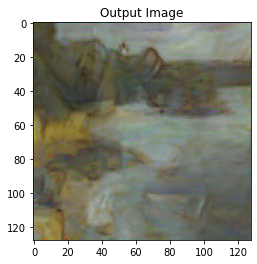

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()